# <center>Automatic Ticket Classification - Case Study</center>

## Problem Statement 

For a financial company, customer complaints carrys a lot of importance, as they are often an indicator of the shortcomings in their products and services. If these complaints are resolved efficiently in time, they can bring down customer dissatisfaction to a minimum and retain them with stronger loyalty. This also gives them an idea of how to continuously improve their services to attract more customers. 

These customer complaints are unstructured text data; so, traditionally, companies need to allocate the task of evaluating and assigning each ticket to the relevant department to multiple support employees. This becomes tedious as the company grows and has a large customer base.

In this case study, we will be working as an NLP engineer for a financial company that wants to automate its customer support tickets system. As a financial company, the firm has many products and services such as 

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


## Business Goals

We need to build a model that is able to classify customer complaints based on the products/services. By doing so, we can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

With the help of non-negative matrix factorization (NMF), an approach under topic modelling, we will detect patterns and recurring words present in each ticket. This can be then used to understand the important features for each cluster of categories. By segregating the clusters, we will be able to identify the topics of the customer complaints. 

We will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, we need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others

With the help of topic modelling, we will be able to map each ticket onto its respective department/category. We can then use this data to train any supervised model such as logistic regression, decision tree, random forest or naive bayes Classification. Using this trained model, we can classify any new customer complaint support ticket into its relevant department.

## NLP Pipelines:

We need to perform the following eight major tasks to classify the tickets raised:

1. Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

<b>Note:</b> Once we have finalised the clusters/categories for customer complaints, the next step is to create a data set that contains the complaints and labels (which you found using NMF). This labelled data set will be used for model building using supervised learning. Models like <b>Logistic Regression, Decision Tree, Random Forest, Naive Bayes Classification</b> can be used to classify the tickest into respective categories. We can then select the best performing model from these based on the evaluation metrics.

In [1]:
#!python -m spacy download en_core_web_md

## Importing required libraries

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint



In [8]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# row/column display limit
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [25]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

## 1. Data loading

### Loading data from JSON file
The data is in JSON format and we need to convert it to a dataframe.

In [9]:
# Opening JSON file 
f = open('complaints.json',) # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

### Data Understanding
We will check and undertsand the shape and size of loaded data.

In [10]:
# Inspect the dataframe to understand the given data.
df.shape

(78313, 22)

In [11]:
## print dataframe info to check column details
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [12]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [13]:
#Assign new column names
cols_new = [re.sub('source.','',col[1:]) for col in df]
print("New columns:\n",cols_new, "\n")


df.columns = cols_new
df.head()

New columns:
 ['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'] 



,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


### Cleaning Data
We will check and address null data in columns and rows

In [14]:
# Checking null count in columns
#df.isnull().sum()
round(df.isna().sum()*100/78313,2)

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         86.08
zip_code                      8.63
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         2.54
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  13.50
timely                        0.00
complaint_what_happened       0.00
sub_issue                    59.12
consumer_consent_provided     1.29
dtype: float64

In [16]:
# printing number of blank rows in complaint column

print("#Rows with complaints blank: ",len(df[(df.complaint_what_happened == "") | (df.complaint_what_happened == " ")]))

#Rows with complaints blank:  57241


In [17]:
#Assign nan in place of blanks in columns compalints
df['complaint_what_happened'] = df['complaint_what_happened'].replace(r"^\s*$",np.NaN,regex=True)
print("No. of rows with nan in complaints column: ", df.complaint_what_happened.isnull().sum())

No. of rows with nan in complaints column:  57241


In [18]:
# blank rows in complaint column after NAN assignment
print("#Rows with blank complaints: ",len(df[(df.complaint_what_happened == "") | (df.complaint_what_happened == " ")]))

#Rows with blank complaints:  0


In [19]:
#Remove rows with complaints column is nan
df = df[~df['complaint_what_happened'].isnull()]

print("New shape : ")
df.shape

New shape : 


(21072, 22)

## 2. Text preprocessing
### Prepare the text for topic modeling

Once we have removed all the blank complaints, we need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once we have done these cleaning operations we need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [20]:
#Func: clean the text and remove all the unnecessary elements.
def text_preprocess(text):
    # Text to lower case
    text_1 = text.lower()
    
    # strip spaces
    text_2 = text_1.strip()
    
    # Removing text within square brackets
    text_3 = re.sub(r"[\[].*?[\]]","",text_2).strip()
    
    # Removing punctuations
    text_4 = re.sub(r"[^\w\s]","",text_3).strip()
    
    # Removing words containing numbers
    text_5 = re.sub("\S*\d\S*","",text_4).strip()   
    
    return text_5

In [23]:
# Applying text_preproces
df['complaints_cleaned'] = df.complaint_what_happened.apply(text_preprocess)
df.head(2)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaints_cleaned
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me


In [26]:
df_clean = df.complaints_cleaned.to_frame()
df_clean.columns = ["complaints"]
df_clean.head()

,complaints
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase


In [29]:
!pip install swifter

  Created wheel for swifter: filename=swifter-1.2.0-py3-none-any.whl size=14483 sha256=677b11188d8a971061ce0f37618f1a2ee570f979b73107cf5c10c490caa02d6e
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\17\fc\36\832a0be8eb0f4e3cb46b97939daf668c621fa52273ed7fc441
Successfully built swifter


In [31]:
import swifter

In [32]:
#Finc : Lemmatize the texts
stopwords = stopwords.words('english')
wordnet_lem = WordNetLemmatizer()

def lemmatizer(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords]
    proc_token = []
    # Using nltk pos tagger which may not capture the context like Spacy's POS tagger. However, it should be good enough for use here.
    for word,pos in pos_tag(tokens):
        try:
            proc_token.append(wordnet_lem.lemmatize(word,pos = pos[0].lower()))
        except:
            proc_token.append(wordnet_lem.lemmatize(word))
    lemmatized_text = ' '.join(proc_token)
    return lemmatized_text

In [33]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[["complaint_what_happened","complaints_cleaned"]]
#df_clean.columns = ["raw_complaints","cleaned_complaints"]

# Apply lemmatization and store the output in a separate column
df_clean["lemmatized_complaints"] = df_clean["complaints_cleaned"].swifter.apply(lemmatizer)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [34]:
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgraded xxxx xxxx card tell agent upgrade anniversary date would change turned agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx without consent xxxx record agent mislead
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application 

In [35]:
#Func: extract the POS tags 
nlp = spacy.load("en_core_web_sm")

from tqdm import tqdm

pos_tags = []  # List to store POS tags of each lemmatized complaint
nouns = []     # List to store only the nouns from the complaint

def pos_tag(text):
    # write your code here
    for complaint in tqdm(text):
        pos = ''
        noun = ''
        proc_complaint = nlp(complaint)
        for tok in proc_complaint:
            pos += tok.pos_ + ' '
            if tok.pos_ in str(('NOUN', 'PROPN')) :
                noun += (tok.lemma_.lower()) + ' '
        pos_tags.append(pos.strip())
        nouns.append(noun.strip())



In [36]:
# Extracting POS tags
pos_tag(df_clean.lemmatized_complaints)

100%|████████████████████████████████████████████████████████████████████████████| 21072/21072 [09:21<00:00, 37.51it/s]


In [37]:
# Validating POS tag for particular row
print(pos_tags[100])
print(nouns[100])

NOUN VERB VERB NOUN NOUN NOUN NOUN PROPN PROPN AUX INTJ VERB NOUN PROPN PROPN VERB ADV VERB NOUN VERB NOUN NOUN PROPN PROPN PROPN PROPN PROPN VERB NOUN NOUN SCONJ PROPN PROPN VERB ADV VERB VERB ADV NOUN NOUN PROPN X PROPN VERB NOUN NOUN SCONJ X PROPN VERB NOUN NOUN PROPN NOUN NOUN NOUN VERB NOUN NOUN ADP NOUN PROPN X PROPN VERB DET NOUN VERB NOUN NOUN ADJ NOUN NOUN NOUN NOUN VERB NOUN NOUN VERB VERB VERB PROPN PROPN PROPN ADV VERB NOUN NOUN NOUN VERB ADJ NOUN ADV ADJ NOUN PROPN PROPN VERB VERB NOUN VERB VERB VERB VERB NOUN NOUN ADV NOUN VERB NOUN PROPN PROPN ADJ ADJ VERB PROPN PROPN NOUN NOUN NOUN VERB VERB VERB ADJ NOUN PROPN PROPN AUX VERB NOUN NOUN AUX VERB ADV NOUN NOUN AUX VERB ADJ NOUN NOUN NOUN NOUN VERB VERB NOUN VERB NOUN VERB NOUN NOUN ADV VERB NOUN VERB NOUN
supervisor complaint regard case managment xxxx xxxx attention mr xxxx representative follow call mr xxxx xxxx xxxx xxxx voice mail xxxx xxxx noon xxxx xxxx xxxx voice mail xxxx voice message return call voice message re

In [38]:
# this column should contain lemmatized text with all the words removed which have tags other than NN
df_clean["complaint_POS_removed"] = pd.Series(pos_tags, index=df_clean.index)
df_clean['complaints_nouns_only'] = pd.Series(nouns, index=df_clean.index)

# Reassigning index of cleaned dataframe
df_clean.reset_index(drop=True, inplace = True)

In [39]:
# dataframe contain the raw complaint, lemmatized complaint and complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,complaint_POS_removed,complaints_nouns_only
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB VERB PROPN PROPN PROPN NOUN VERB PROPN VERB NOUN NOUN VERB NOUN ADJ PROPN NOUN NOUN NOUN ADV VERB NOUN DET NOUN NOUN VERB NOUN ADV VERB NOUN NOUN NOUN NOUN NOUN PROPN PROPN PROPN NOUN NOUN NOUN,morning name xxxx xxxx chase bank cardmember service chase debt verification statement ask bank validate debt mail month attempt debt information consumer chase account xxxx xxxx xxxx xxxx thank advance help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgraded xxxx xxxx card tell agent upgrade anniversary date would change turned agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx without consent xxxx record agent mislead,VERB ADJ PROPN PROPN VERB NOUN VERB NOUN NOUN AUX VERB VERB NOUN VERB ADJ NOUN NOUN VERB NOUN NOUN VERB NOUN NOUN PROPN PROPN ADP NOUN ADJ NOUN NOUN VERB,xxxx card agent anniversary date agent information order account xxxx anniversary date xxxxxxxx xxxxxxxx consent record agent
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,PROPN NOUN NOUN ADV ADJ NOUN NOUN NOUN ADP NOUN ADV VERB NOUN VERB NOUN ADP NOUN NOUN NOUN,chase card report application submit identity consent service credit verify identity applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information f

### Exploratory data analysis to get familiar with the data.

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [43]:
df_clean.complaint_what_happened.str.len().sort_values(ascending=False)

436      31611
11241    31385
14251    29948
2308     29239
1130     25757
9031     25450
9467     23778
5880     22791
3924     22028
8799     21175
4741     20189
20197    19610
19025    19554
131      19547
20751    19545
19879    19488
13622    19161
5905     17676
17482    17596
16001    17549
11808    17117
4604     16755
11914    16585
4662     15976
20241    15875
654      15784
9236     15496
1914     15120
6068     15054
16406    14520
10818    14444
3107     14430
2400     14169
16138    14044
12882    13769
9163     13765
4030     13519
11238    13385
1213     13292
4194     13145
2854     13144
4151     12937
4564     12857
1511     12800
5058     12526
5429     12418
17919    12059
5573     11940
5655     11939
5903     11847
15999    11821
5925     11735
15785    11651
7087     11609
7740     11564
11400    11346
5347     11213
7420     11061
12939    10942
17698    10797
6104     10731
4468     10704
3743     10637
2363     10632
20176    10547
12624    10516
11002    1

Text(0.5, 0, 'Character ranges')

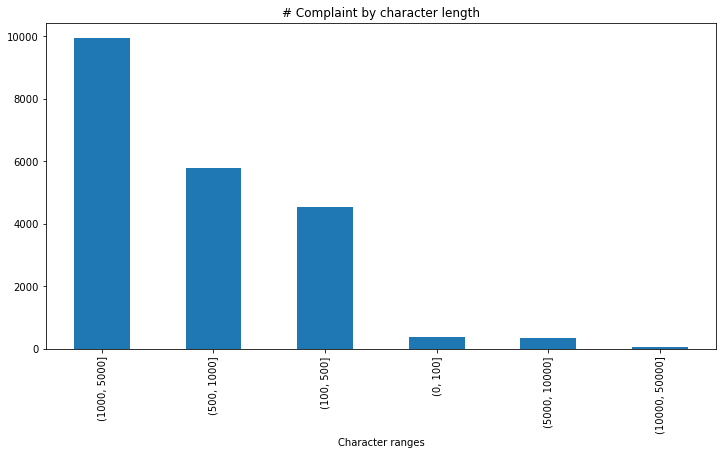

In [44]:
# Write your code here to visualise the data according to the 'Complaint' character length
bins = [0, 100, 500, 1000, 5000, 10000, 50000]
temp_df = df_clean.complaint_what_happened.str.len().to_frame()
temp_df.columns = ["length"]
temp_df['binned'] = pd.cut(temp_df['length'], bins)
temp_df.binned.value_counts()

plt.figure(figsize=(12,6))
temp_df.binned.value_counts().plot(kind="bar")
plt.title("# Complaint by character length")
plt.xlabel("Character ranges")

#### Find the top 40 words by frequency among all the articles after processing the text.

Text(0.5, 1.0, 'Most frequent words in complaints after processing')

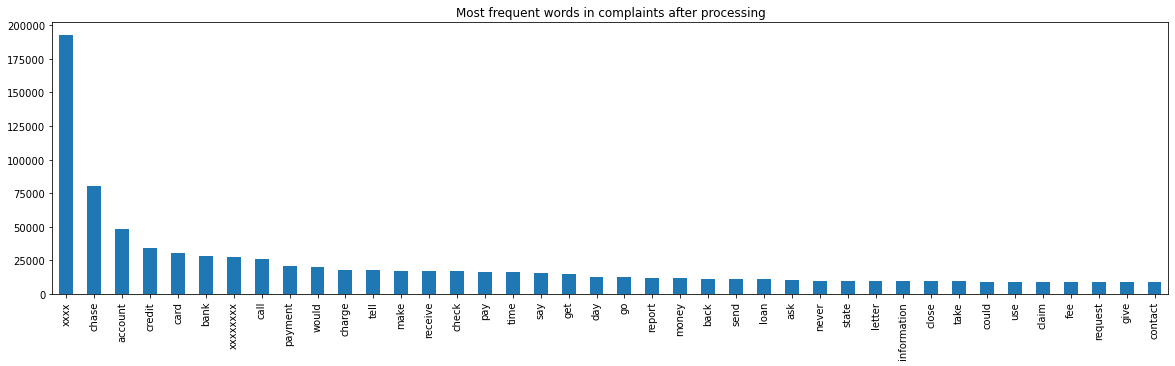

In [45]:
# Most frequent words in the processed (lemmatized) complaints
most_freq_lem=[] # List to extract most frequent words

for complaint in df_clean.lemmatized_complaints:
    for word in complaint.split(' '):
        most_freq_lem.append(word)

plt.figure(figsize=(20, 5)) 
pd.DataFrame(most_freq_lem)[0].value_counts().head(40).plot(kind='bar')
plt.title("Most frequent words in complaints after processing")

In [48]:
#!pip install wordcloud

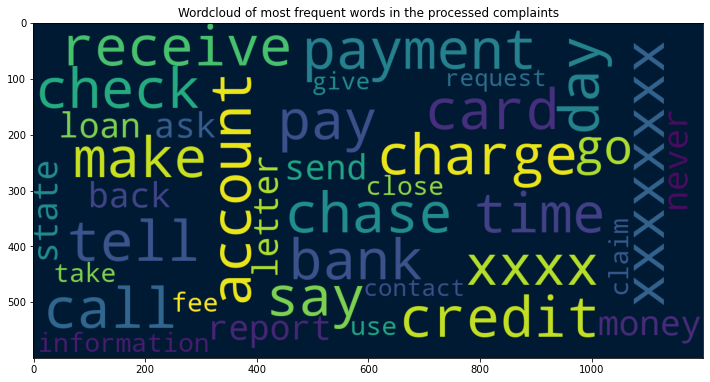

In [49]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

plt.figure(figsize=(12, 12))
wordcloud = WordCloud(background_color = '#001a33', width = 1200, height = 600, colormap = 'viridis', max_words = 50, contour_width = 3, max_font_size = 100, contour_color = 'steelblue', random_state = 0)

most_freq_words = pd.DataFrame(most_freq_lem)[0].value_counts().head(40).index
wordcloud.generate(' '.join([w for w in most_freq_words]))

plt.imshow(wordcloud)
plt.title("Wordcloud of most frequent words in the processed complaints")
plt.show()

In [50]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [51]:
from nltk.util import ngrams 
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

### Unigrams

In [52]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word') 
word_vect = vectorizer.fit_transform(df_clean['complaints_nouns_only']) 
freqs = sum(word_vect).toarray()[0]

unigram_df = pd.DataFrame(freqs, index=vectorizer.get_feature_names(), columns=['frequency'])
unigram_df.sort_values(by="frequency", ascending = False).head(30)

,frequency
xxxx,154667
chase,78800
account,46689
credit,33964
card,30415
bank,28601
xxxxxxxx,27905
payment,21161
call,18453
time,16048


In [53]:
#Print the top 10 words in the unigram frequency
print("Top 10 words in the unigram by frequency:")
unigram_df.sort_values(by="frequency", ascending = False).head(10)

Top 10 words in the unigram by frequency:


,frequency
xxxx,154667
chase,78800
account,46689
credit,33964
card,30415
bank,28601
xxxxxxxx,27905
payment,21161
call,18453
time,16048


<Figure size 1440x360 with 0 Axes>

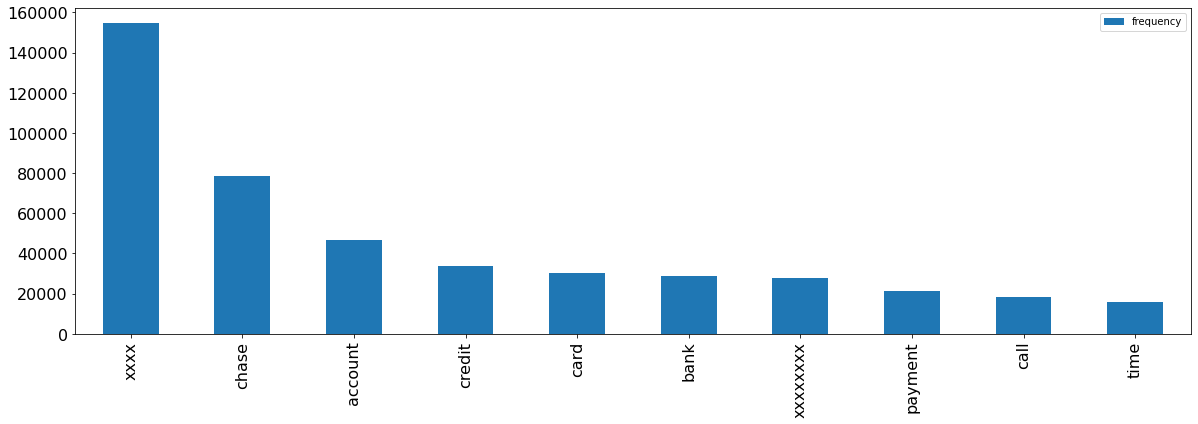

In [54]:
plt.figure(figsize=(20, 5))
unigram_df.sort_values(by='frequency', ascending=False)[:10].plot(kind='bar', figsize=(20,6), fontsize=16)
plt.show()

### Bigrams

In [55]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer_bigram = CountVectorizer(ngram_range=(2, 2), analyzer='word') 
word_vector_bigram = vectorizer_bigram.fit_transform(df_clean['complaints_nouns_only']) 
freqs_bigram = sum(word_vector_bigram).toarray()[0]

bigram_df = pd.DataFrame(freqs_bigram, index=vectorizer_bigram.get_feature_names(), columns=['frequency'])
print(bigram_df.sort_values(by="frequency", ascending = False).head(30))

                   frequency
xxxx xxxx              67013
chase bank             12897
credit card            12840
xxxx chase              5473
call chase              4308
credit report           3993
xxxxxxxx xxxx           3638
check account           3551
chase xxxx              3442
chase credit            3384
xxxx xxxxxxxx           3187
account chase           3135
customer service        3080
jp morgan               2764
account xxxx            2634
xxxx account            2623
xxxxxxxx xxxxxxxx       2596
bank account            2512
morgan chase            2475
chase account           2471
xxxx credit             2369
contact chase           1888
bank xxxx               1886
debit card              1881
number xxxx             1849
call xxxx               1779
xxxxxxxx chase          1760
credit score            1713
phone call              1704
chase card              1650


Top 10 bigrams by frequency:
               frequency
xxxx xxxx          67013
chase bank         12897
credit card        12840
xxxx chase          5473
call chase          4308
credit report       3993
xxxxxxxx xxxx       3638
check account       3551
chase xxxx          3442
chase credit        3384


<Figure size 1440x360 with 0 Axes>

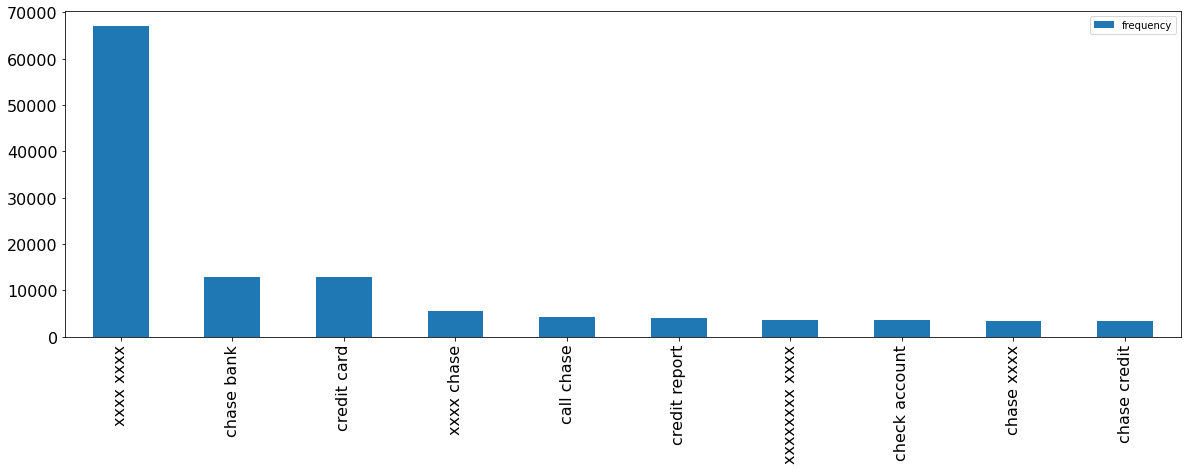

In [59]:
#Print the top 10 words in the bigram frequency
print("Top 10 bigrams by frequency:")
print(bigram_df.sort_values(by="frequency", ascending = False).head(10))

plt.figure(figsize=(20, 5))
bigram_df.sort_values(by='frequency', ascending=False)[:10].plot(kind='bar', figsize=(20,6), fontsize=16)
plt.show()

### Trigrams

In [60]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer_trigram = CountVectorizer(ngram_range=(3,3), analyzer='word') 
word_vector_trigram = vectorizer_trigram.fit_transform(df_clean['complaints_nouns_only']) 
freqs_trigram = sum(word_vector_trigram).toarray()[0]

trigram_df = pd.DataFrame(freqs_trigram, index=vectorizer_trigram.get_feature_names(), columns=['frequency'])
print(trigram_df.sort_values(by="frequency", ascending = False).head(30))

                            frequency
xxxx xxxx xxxx                  32438
chase credit card                2351
xxxx xxxx chase                  2348
jp morgan chase                  2302
xxxxxxxx xxxx xxxx               1834
xxxx xxxx xxxxxxxx               1449
chase xxxx xxxx                  1340
chase bank xxxx                  1142
xxxx credit card                 1101
xxxx xxxxxxxx xxxx               1087
credit card account              1031
account xxxx xxxx                 978
credit card company               970
xxxx xxxx account                 948
xxxx chase bank                   913
bank xxxx xxxx                    884
credit card chase                 845
xxxx xxxx credit                  792
account chase bank                765
name xxxx xxxx                    703
chase bank account                694
morgan chase bank                 679
xxxxxxxx xxxxxxxx xxxxxxxx        672
call xxxx xxxx                    659
chase customer service            622
credit card 

Top 10 trigrams by frequency:
                    frequency
xxxx xxxx xxxx          32438
chase credit card        2351
xxxx xxxx chase          2348
jp morgan chase          2302
xxxxxxxx xxxx xxxx       1834
xxxx xxxx xxxxxxxx       1449
chase xxxx xxxx          1340
chase bank xxxx          1142
xxxx credit card         1101
xxxx xxxxxxxx xxxx       1087


<Figure size 1440x360 with 0 Axes>

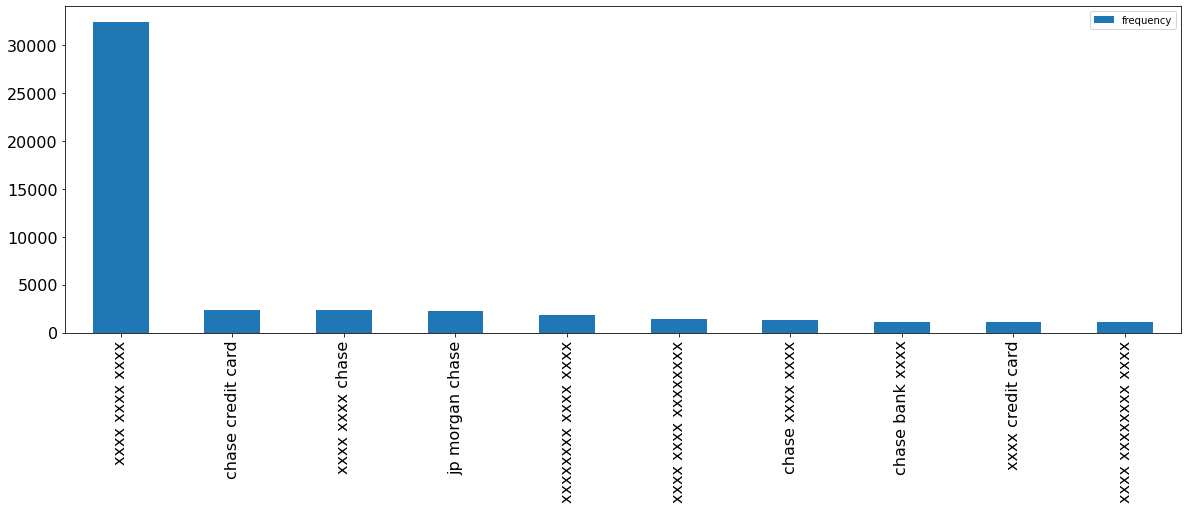

In [61]:
#Print the top 10 words in the trigram frequency
print("Top 10 trigrams by frequency:")
print(trigram_df.sort_values(by="frequency", ascending = False).head(10))

plt.figure(figsize=(20, 5))
trigram_df.sort_values(by='frequency', ascending=False)[:10].plot(kind='bar', figsize=(20,6), fontsize=16)
plt.show()

### The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as masked texts will be of no use for our analysis.

In [62]:
# Replacing masked text ("xxxx")
df_clean['complaints_cleaned'] = df_clean['complaints_cleaned'].str.replace('xxxx','')
df_clean['lemmatized_complaints'] = df_clean['lemmatized_complaints'].str.replace('xxxx','')
df_clean['complaints_nouns_only'] = df_clean['complaints_nouns_only'].str.replace('xxxx','')

In [63]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,complaint_POS_removed,complaints_nouns_only,Complaint_clean
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account thanks in advance for your help,good morning name appreciate could help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account thanks advance help,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB VERB PROPN PROPN PROPN NOUN VERB PROPN VERB NOUN NOUN VERB NOUN ADJ PROPN NOUN NOUN NOUN ADV VERB NOUN DET NOUN NOUN VERB NOUN ADV VERB NOUN NOUN NOUN NOUN NOUN PROPN PROPN PROPN NOUN NOUN NOUN,morning name chase bank cardmember service chase debt verification statement ask bank validate debt mail month attempt debt information consumer chase account thank advance help,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB VERB PROPN PROPN PROPN NOUN VERB PROPN VERB NOUN NOUN VERB NOUN ADJ PROPN NOUN NOUN NOUN ADV VERB NOUN DET NOUN NOUN VERB NOUN ADV VERB NOUN NOUN NOUN NOUN NOUN PROPN PROPN PROPN NOUN NOUN NOUN
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,upgraded card tell agent upgrade anniversary date would change turned agent give wrong information order upgrade account change anniversary date without consent record agent mislead,VERB ADJ PROPN PROPN VERB NOUN VERB NOUN NOUN AUX VERB VERB NOUN VERB ADJ NOUN NOUN VERB NOUN NOUN VERB NOUN NOUN PROPN PROPN ADP NOUN ADJ NOUN NOUN VERB,card agent anniversary date agent information order account anniversary date consent record agent,VERB ADJ PROPN PROPN VERB NOUN VERB NOUN NOUN AUX VERB VERB NOUN VERB ADJ NOUN NOUN VERB NOUN NOUN VERB NOUN NOUN PROPN PROPN ADP NOUN ADJ NOUN NOUN VERB
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,PROPN NOUN NOUN ADV ADJ NOUN NOUN NOUN ADP NOUN ADV VERB NOUN VERB NOUN ADP NOUN NOUN NOUN,chase card report application submit identity consent service credi

## 4. Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [96]:
#Write your code here to initialise the TfidfVectorizer 

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.95,
    max_features=5000, # Keeping max_features to 5000 to keep within memory limits.
    ngram_range=(1, 3)
)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [97]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf = tfidf_vectorizer.fit_transform(df_clean['complaints_nouns_only'])
features = tfidf_vectorizer.get_feature_names()

# Creating a dataframe to display the document-term matrix created above
tfidf_df = pd.DataFrame(tfidf.toarray(), columns = features)
tfidf_df.head()

ability  abuse  acceptance  access  access account  access bank  \
0      0.0    0.0         0.0     0.0             0.0          0.0   
1      0.0    0.0         0.0     0.0             0.0          0.0   
2      0.0    0.0         0.0     0.0             0.0          0.0   
3      0.0    0.0         0.0     0.0             0.0          0.0   
4      0.0    0.0         0.0     0.0             0.0          0.0   

   access chase  access credit  access fund  access information  access money  \
0           0.0            0.0          0.0                 0.0           0.0   
1           0.0            0.0          0.0                 0.0           0.0   
2           0.0            0.0          0.0                 0.0           0.0   
3           0.0            0.0          0.0                 0.0           0.0   
4           0.0            0.0          0.0                 0.0           0.0   

   accident  accommodation  accord  accord chase  accordance   account  \
0       0.0            0.0     0.0           0.0         0.0  0.055268   
1       0.0            0.0     0.0           0.0         0.0  0.068648   
2       0.0            0.0     0.0           0.0         0.0  0.000000   
3       0.0            0.0     0.0           0.0         0.0  0.097042   
4       0.0            0.0     0.0           0.0         0.0  0.087703   

   account access  account account  account account account  \
0             0.0              0.0                      0.0   
1             0.0              0.0                      0.0   
2             0.0              0.0                      0.0   
3             0.0              0.0                      0.0   
4             0.0              0.0                      0.0   

   account account balance  account account chase  account account number  \
0                      0.0                    0.0                     0.0   
1                      0.0                    0.0                     0.0   
2                      0.0                    0.0                     0.0   
3                      0.0                    0.0                     0.0   
4                      0.0                    0.0                     0.0   

   account activity  account address  account advise  account agreement  \
0               0.0              0.0             0.0                0.0   
1               0.0              0.0             0.0                0.0   
2               0.0              0.0             0.0                0.0   
3               0.0              0.0             0.0                0.0   
4               0.0              0.0             0.0                0.0   

   account amount  account ask  account atm  account attempt  account balance  \
0             0.0     0.000000          0.0              0.0              0.0   
1             0.0     0.000000          0.0              0.0              0.0   
2             0.0     0.000000          0.0              0.0              0.0   
3             0.0     0.117755          0.0              0.0              0.0   
4             0.0     0.000000          0.0              0.0              0.0   

   account balance account  account balance chase  account bank  \
0                      0.0                    0.0           0.0   
1                      0.0                    0.0           0.0   
2                      0.0                    0.0           0.0   
3                      0.0                    0.0           0.0   
4                      0.0                    0.0           0.0   

   account bank account  account banker  account base  account bill  \
0                   0.0             0.0           0.0           0.0   
1                   0.0             0.0           0.0           0.0   
2                   0.0             0.0           0.0           0.0   
3                   0.0             0.0           0.0           0.0   
4                   0.0             0.0           0.0           0.0   

   account block  account bonus  account

In [98]:
tfidf_df.shape

(21072, 5000)

In [99]:
len(tfidf_vectorizer.get_feature_names())

5000

## 5. Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [100]:
from sklearn.decomposition import NMF

### Manual Topic Modeling
We need to take the trial & error approach to find the best num of topics for our NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [101]:
#Starting with 15 topics

In [102]:
#Load your nmf_model with the n_components i.e 15
num_topics = 15 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [103]:
W = nmf_model.fit_transform(tfidf)  # Document-Topic matrix
H = nmf_model.components_           # Topic-Term matrix

In [104]:
#Print the Top 15 words for each of the topics
words = np.array(tfidf_vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,account chase,chase account,account account,chase,check account,bank account,reason,access,transfer,balance,branch,card account,money account,business
Topic 2,card,credit,credit card,chase credit,chase credit card,chase,card chase,chase card,score,card account,card credit,credit card chase,limit,use,credit score
Topic 3,mortgage,home,property,chase,chase mortgage,modification,foreclosure,house,year,sale,mortgage payment,escrow,tax,insurance,bankruptcy
Topic 4,inquiry,inquiry credit,inquiry credit report,credit report,credit,jpmcb,credit inquiry,card inquiry,report inquiry,jpmcb card,inquiry inquiry,report,inquiry chase,credit report inquiry,application
Topic 5,payment,payment payment,month,payment chase,pay,chase payment,amount,chase,day,payment credit,time,payment account,payment month,auto,payment time
Topic 6,charge,dispute,merchant,dispute charge,company,chase,charge chase,charge account,purchase,amount,refund,charge charge,chase charge,item,charge credit
Topic 7,fee,overdraft,overdraft fee,charge,charge fee,fee charge,transaction,charge overdraft,fee account,charge overdraft fee,pay,fee fee,fee chase,time,year
Topic 8,morgan,jp,jp morgan,morgan chase,jp morgan chase,morgan chase bank,chase,complaint,account jp,account jp morgan,morgan chase credit,bank jp,bank jp morgan,foreclosure,request
Topic 9,bank,chase bank,chase,bank account,money,bank chase,chase bank account,account chase bank,bank bank,bank credit,bank chase bank,call chase bank,wire,complaint,chase bank credit
Topic 10,call,chase,phone,number,letter,email,information,time,customer,service,state,request,day,contact,address


In [105]:
#Trying with 10 topics

In [106]:
#Load your nmf_model with the n_components 

# Trying 10 topics
num_topics = 10 #write the value you want to test out

#random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

W = nmf_model.fit_transform(tfidf)  # Document-Topic matrix
H = nmf_model.components_           # Topic-Term matrix

words = np.array(tfidf_vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,chase,call,claim,number,transaction,phone,email,day,fraud,information,time,money,letter,customer,state
Topic 2,card,credit,credit card,chase,chase credit,chase credit card,card chase,card account,chase card,score,account,limit,balance,credit card account,year
Topic 3,loan,mortgage,modification,chase,home,property,year,rate,foreclosure,loan modification,house,sale,refinance,document,chase mortgage
Topic 4,report,inquiry,credit,credit report,inquiry credit,inquiry credit report,bureau,report credit,credit bureau,jpmcb,information,reporting,debt,company,identity
Topic 5,payment,payment payment,month,pay,balance,payment chase,chase,statement,chase payment,interest,amount,auto,time,day,bill
Topic 6,charge,dispute,merchant,dispute charge,chase,company,charge chase,purchase,charge account,amount,refund,charge charge,item,fraud,chase charge
Topic 7,fee,overdraft,balance,charge,overdraft fee,interest,charge fee,transaction,pay,fee charge,transfer,rate,charge overdraft,fee account,charge overdraft fee
Topic 8,morgan,jp,jp morgan,morgan chase,jp morgan chase,morgan chase bank,chase,complaint,account jp,account jp morgan,morgan chase credit,foreclosure,bank jp,bank jp morgan,request
Topic 9,bank,chase bank,chase,money,bank account,bank chase,chase bank account,account chase bank,bank bank,bank money,cash,bank chase bank,bank credit,call chase bank,wire
Topic 10,account,check,deposit,fund,check account,chase,money,account chase,branch,chase account,account account,day,business,reason,access


In [107]:
# Trying with 5 topics

In [108]:
#Load your nmf_model with the n_components 

# Trying 5 topics
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

W = nmf_model.fit_transform(tfidf)  # Document-Topic matrix
H = nmf_model.components_           # Topic-Term matrix

words = np.array(tfidf_vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,chase,money,deposit,chase bank,fund,transaction,branch,call,day,check account,claim,account chase
Topic 2,card,credit,credit card,charge,chase,dispute,chase credit,purchase,chase credit card,call,merchant,company,service,time,card chase
Topic 3,loan,mortgage,chase,modification,home,property,morgan,jp,jp morgan,document,foreclosure,year,letter,morgan chase,jp morgan chase
Topic 4,credit,report,inquiry,credit report,inquiry credit,inquiry credit report,bureau,account,report credit,credit bureau,debt,score,jpmcb,reporting,information
Topic 5,payment,balance,fee,interest,month,pay,payment payment,statement,payment chase,amount,chase payment,chase,bill,time,account


In [109]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_mapping_num = {
    'Topic 1' : 0,
    'Topic 2' : 1,
    'Topic 3' : 2,
    'Topic 4' : 3,
    'Topic 5' : 4
}

In [110]:
W = pd.DataFrame(W, columns=[f'Topic {i+1}' for i in range(num_topics)])
W['max_topic'] = W.apply(lambda x: topic_mapping_num.get(x.idxmax()) if x.idxmax() in topic_mapping_num.keys() else '4', axis=1)
W[pd.notnull(W['max_topic'])].head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.023112,0.005104,0.019724,0.012145,0.003998,0
1,0.006182,0.014788,0.004783,0.002566,0.000707,1
2,0.000000,0.022435,0.002206,0.038814,0.000000,3
3,0.019068,0.021018,0.017115,0.062396,0.000000,3
4,0.062723,0.000000,0.001408,0.000000,0.000000,0
5,0.000000,0.000000,0.000000,0.105327,0.000000,3
6,0.051567,0.003615,0.010213,0.000000,0.010765,0
7,0.001872,0.005854,0.041531,0.000240,0.049191,4
8,0.040059,0.026694,0.020860,0.003407,0.001497,0
9,0.000000,0.050606,0.000000,0.072724,0.000000,3


In [111]:
# Checking the frequency of each identified topic
W['max_topic'].value_counts()

1    6160
0    6026
2    3895
4    2534
3    2457
Name: max_topic, dtype: int64

In [112]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] =W['max_topic'].apply(lambda x:int(x))

In [113]:
df_clean.tail()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,complaint_POS_removed,complaints_nouns_only,Complaint_clean,Topic
21067,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for acquiring new credit cards with Chase - all with bonus airline miles and hotel points. Was approved for all ( 3 ) new cards with No annual fee for 1st year. After less than 2 months with payment always paid as agreed, Chase closed all my cards. One of my ( 3 ) approved new cards was never activated but was sent to me.\n\nChase has done harm to my credit, has charged me an annual fee even though they cancelled my account, failed to credit my points for both airlines and hotel, failed to credit up to {$100.00} for XXXX enrollment and failed to credit airline charge as agreed upon",after being a chase card customer for well over a decade was offered multiple solicitations for acquiring new credit cards with chase all with bonus airline miles and hotel points was approved for all new cards with no annual fee for year after less than months with payment always paid as agreed chase closed all my cards one of my approved new cards was never activated but was sent to me\n\nchase has done harm to my credit has charged me an annual fee even though they cancelled my account failed to credit my points for both airlines and hotel failed to credit up to for enrollment and failed to credit airline charge as agreed upon,chase card customer well decade offer multiple solicitation acquire new credit card chase bonus airline mile hotel point approve new card annual fee year less month payment always pay agree chase close card one approve new card never activate sent chase do harm credit charge annual fee even though cancelled account fail credit point airline hotel fail credit enrollment fail credit airline charge agree upon,PROPN NOUN NOUN ADJ NOUN VERB ADJ NOUN VERB ADJ NOUN NOUN NOUN NOUN NOUN NOUN NOUN NOUN VERB ADJ NOUN ADJ NOUN NOUN ADJ NOUN NOUN ADV VERB NOUN NOUN ADJ NOUN PRON VERB ADJ NOUN ADV VERB VERB PROPN AUX VERB NOUN NOUN ADJ NOUN ADV SCONJ VERB NOUN NOUN NOUN NOUN NOUN NOUN NOUN NOUN PROPN NOUN NOUN NOUN NOUN NOUN VERB SCONJ,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fee year month payment agree chase card card chase credit charge fee account fail credit point airline hotel fail credit enrollment fail credit airline charge,PROPN NOUN NOUN ADJ NOUN VERB ADJ NOUN VERB ADJ NOUN NOUN NOUN NOUN NOUN NOUN NOUN NOUN VERB ADJ NOUN ADJ NOUN NOUN ADJ NOUN NOUN ADV VERB NOUN NOUN ADJ NOUN PRON VERB ADJ NOUN ADV VERB VERB PROPN AUX VERB NOUN NOUN ADJ NOUN ADV SCONJ VERB NOUN NOUN NOUN NOUN NOUN NOUN NOUN NOUN PROPN NOUN NOUN NOUN NOUN NOUN VERB SCONJ,1
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to make a claim under their purchase protection benefit. On XX/XX/XXXX, I purchased three high school textbooks for my XXXX year old daughter because she transferred to a new school. All three books were damaged when a water bottle in her backpack broke. The Chase representative assured me the textbooks would be covered and instructed me to file a claim at XXXX. I immediately went to the website and filed the claim, including uploading all of the requested paperwork which included a copy of my credit card statement, copies of the three receipts and photographic evidence of the damage. The website even had "" books '' as one of the catagories I could list as the type of item they cover and that I could make a claim on. After following up repeatedly on my claim since the insurance provider failed to "" review my information and contact me within 5 business days to outline the next steps of the process, '' as outlined in an email I received acknowledging my claim submission, I called to complain. The representative said claims are not looked at by an examiner "" for eight to ten days '' and then it would take "" two

In [114]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaint_what_happened  21072 non-null  object
 1   complaints_cleaned       21072 non-null  object
 2   lemmatized_complaints    21072 non-null  object
 3   complaint_POS_removed    21072 non-null  object
 4   complaints_nouns_only    21072 non-null  object
 5   Complaint_clean          21072 non-null  object
 6   Topic                    21072 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


In [115]:
#Print the first 5 Complaint for each of the Topics
df_clean_sample = df_clean.groupby('Topic').head(5)

#df_clean_sample.sort_values('Topic')
df_clean_sample.sort_values(by='Topic')

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,complaint_POS_removed,complaints_nouns_only,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account thanks in advance for your help,good morning name appreciate could help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account thanks advance help,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB VERB PROPN PROPN PROPN NOUN VERB PROPN VERB NOUN NOUN VERB NOUN ADJ PROPN NOUN NOUN NOUN ADV VERB NOUN DET NOUN NOUN VERB NOUN ADV VERB NOUN NOUN NOUN NOUN NOUN PROPN PROPN PROPN NOUN NOUN NOUN,morning name chase bank cardmember service chase debt verification statement ask bank validate debt mail month attempt debt information consumer chase account thank advance help,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB VERB PROPN PROPN PROPN NOUN VERB PROPN VERB NOUN NOUN VERB NOUN ADJ PROPN NOUN NOUN NOUN ADV VERB NOUN DET NOUN NOUN VERB NOUN ADV VERB NOUN NOUN NOUN NOUN NOUN PROPN PROPN PROPN NOUN NOUN NOUN,0
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number claim number is with chase,grand son give check deposit chase account fund clear chase bank close account never pay money say need speek grand son check clear money take chase bank refuse pay money grand son call chase time tell call verify check owner country time date happen check number claim number chase,ADJ PROPN VERB NOUN NOUN PROPN PROPN PROPN PROPN PROPN PROPN ADJ NOUN ADV VERB NOUN VERB VERB ADJ ADJ NOUN VERB ADJ NOUN VERB PROPN PROPN VERB VERB NOUN ADJ PROPN PROPN PROPN PROPN VERB VERB VERB NOUN NOUN NOUN NOUN NOUN VERB NOUN NOUN NOUN VERB NOUN PROPN PROPN,son check deposit chase account fund clear chase bank account money son money chase bank money son call chase time check owner country time date check number number chase,ADJ PROPN VERB NOUN NOUN PROPN PROPN PROPN PROPN PROPN PROPN ADJ NOUN ADV VERB NOUN VERB VERB ADJ ADJ NOUN VERB ADJ NOUN VERB PROPN PROPN VERB VERB NOUN ADJ PROPN PROPN PROPN PROPN VERB VERB VERB NOUN NOUN NOUN NOUN NOUN VERB NOUN NOUN NOUN VERB NOUN PROPN PROPN,0
10,mishandling of this account by Chase auto and XXXX.,mishandling of this account 

In [116]:
# Checking whether each complaint has an assigned topic or not; and whether the count for each topic matches that from our Document-Topic matrix
df_clean.Topic.value_counts()

1    6160
0    6026
2    3895
4    2534
3    2457
Name: Topic, dtype: int64

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Mortgage/Loan
* Theft/Dispute Reporting
* Others

In [117]:
#Create the dictionary of Topic names and Topics

Topic_names =   {
                0 : "Bank account services",
                1 : "Credit Card/Prepaid Card",
                2 : "Mortgages/loans",
                3 : "Theft/Dispute reporting",
                4 : "Others"
                }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [118]:
df_clean.Topic.value_counts()

Credit Card/Prepaid Card    6160
Bank account services       6026
Mortgages/loans             3895
Others                      2534
Theft/Dispute reporting     2457
Name: Topic, dtype: int64

## 6. Model building using supervised learning

### Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [119]:
#Create the dictionary again of Topic names and Topics

topic_labels = {
    "Bank account services" : 0,
    "Credit Card/Prepaid Card" : 1,
    "Mortgages/loans" : 2,
    "Theft/Dispute reporting" : 3,
    "Others" : 4
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_labels)

In [121]:
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,complaint_POS_removed,complaints_nouns_only,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account thanks in advance for your help,good morning name appreciate could help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account thanks advance help,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB VERB PROPN PROPN PROPN NOUN VERB PROPN VERB NOUN NOUN VERB NOUN ADJ PROPN NOUN NOUN NOUN ADV VERB NOUN DET NOUN NOUN VERB NOUN ADV VERB NOUN NOUN NOUN NOUN NOUN PROPN PROPN PROPN NOUN NOUN NOUN,morning name chase bank cardmember service chase debt verification statement ask bank validate debt mail month attempt debt information consumer chase account thank advance help,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB VERB PROPN PROPN PROPN NOUN VERB PROPN VERB NOUN NOUN VERB NOUN ADJ PROPN NOUN NOUN NOUN ADV VERB NOUN DET NOUN NOUN VERB NOUN ADV VERB NOUN NOUN NOUN NOUN NOUN PROPN PROPN PROPN NOUN NOUN NOUN,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,upgraded card tell agent upgrade anniversary date would change turned agent give wrong information order upgrade account change anniversary date without consent record agent mislead,VERB ADJ PROPN PROPN VERB NOUN VERB NOUN NOUN AUX VERB VERB NOUN VERB ADJ NOUN NOUN VERB NOUN NOUN VERB NOUN NOUN PROPN PROPN ADP NOUN ADJ NOUN NOUN VERB,card agent anniversary date agent information order account anniversary date consent record agent,VERB ADJ PROPN PROPN VERB NOUN VERB NOUN NOUN AUX VERB VERB NOUN VERB ADJ NOUN NOUN VERB NOUN NOUN VERB NOUN NOUN PROPN PROPN ADP NOUN ADJ NOUN NOUN VERB,1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,PROPN NOUN NOUN ADV ADJ NOUN NOUN NOUN ADP NOUN ADV VERB NOUN VERB NOUN ADP NOUN NOUN NOUN,chase card report application submit identity consent ser

In [122]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["complaint_what_happened","Topic"]]

In [123]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaint_what_happened  21072 non-null  object
 1   Topic                    21072 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 329.4+ KB


In [124]:
training_data.head()

,complaint_what_happened,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",3
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",3
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,0


In [125]:
training_data.Topic.value_counts()

1    6160
0    6026
2    3895
4    2534
3    2457
Name: Topic, dtype: int64

In [126]:
#Write your code to get the Vector count
vectorizer = CountVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.95, min_df=0.02)
vector = vectorizer.fit_transform(training_data.complaint_what_happened)

print(vector.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [6 0 0 ... 1 1 0]
 [2 0 0 ... 3 1 0]]


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [127]:
#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer =TfidfTransformer(use_idf=True).fit(vector)
word_vect = tfidf_transformer.transform(vector)
word_vect.shape

(21072, 883)

In [128]:
word_vect_df = pd.DataFrame(word_vect.toarray(),columns=vectorizer.get_feature_names(),index=training_data.index)
word_vect_df.head()

,00,00 account,00 chase,00 xx,00 xx xx,00 xxxx,00 xxxx xxxx,10,10 days,100,100 00,1000,1000 00,12,15,18,19,20,200,200 00,2000,2000 00,2015,2016,2017,2018,2019,2020,24,30,30 days,50,500,500 00,60,90,ability,able,absolutely,accept,accepted,access,according,account,account chase,account chase bank,account closed,account number,account xx,account xx xx,account xxxx,account xxxx xxxx,accounts,act,action,actions,activity,actually,add,added,addition,additional,address,advised,agencies,agency,agent,ago,agreed,agreement,alert,allow,allowed,amazon,amounts,annual,answer,app,apparently,appears,application,applied,apply,approval,approved,approximately,ask,asked,asking,assist,assistance,assured,atm,attached,attempt,attempted,attempts,attorney,authorization,authorize,authorized,auto,available,avoid,aware,away,bad,balance,bank,bank account,bank chase,bank xx,bank xx xx,bank xxxx,bank xxxx xxxx,banker,banking,bankruptcy,banks,based,began,beginning,behalf,believe,best,better,billing,bills,bonus,branch,branch manager,branch xxxx,bureau,bureaus,business,business days,buy,ca,called,called chase,called xxxx,called xxxx xxxx,calling,calls,came,cancel,cancelled,car,card,card account,card chase,card company,card xx,card xx xx,card xxxx,cards,care,case,cash,cause,caused,causing,cfpb,change,changed,charge,charged,charges,charging,chase,chase account,chase bank,chase bank xxxx,chase branch,chase card,chase chase,chase checking,chase closed,chase credit,chase credit card,chase customer,chase customer service,chase did,chase freedom,chase mortgage,chase representative,chase said,chase sent,chase told,chase xx,chase xx xx,chase xxxx,chase xxxx xxxx,check,check xxxx,checked,checking,checking account,checks,claim,claimed,claiming,claims,clear,cleared,clearly,close,close account,closed,closed account,closing,code,collect,collection,come,communication,companies,company,complaint,complaint chase,complaints,complete,completed,completely,concern,confirm,confirmation,confirmed,consumer,consumers,contact,contact chase,contacted,contacted chase,contacted xxxx,contacting,continue,continued,contract,conversation,copies,copy,correct,correspondence,cost,couple,course,court,cover,covid,credit,credit account,credit bureaus,credit card,credit card account,credit card chase,credit card company,credit cards,credit report,credit reporting,credit reports,credit score,credited,current,currently,customer,customer service,customers,date,date xx,date xx xx,dated,dated xx,dated xx xx,dates,day,days,days later,deal,debit,debit card,debt,decided,decision,declined,denied,department,deposit,deposited,deposits,dept,despite,details,did,did receive,didn,didnt,different,direct,directly,discovered,dispute,disputed,document,documentation,documents,does,doing,dollars,don,dont,early,email,emailed,emails,employee,employees,end,ended,ending,ending xxxx,entire,error,escrow,evidence,executive,executive office,explain,explained,explanation,extra,extremely,fact,failed,fair,false,family,far,fault,fax,federal,fee,feel,fees,file,filed,filing,final,finally,finance,financial,fine,fix,fixed,follow,followed,following,forced,foreclosure,form,forward,fraud,fraud department,fraudulent,free,freedom,friday,funds,future,gave,getting,given,giving,going,gone,good,got,government,happen,happened,hard,having,hear,heard,held,help,high,higher,history,hold,holder,holding,home,honor,hour,hours,house,husband,id,idea,identity,identity theft,illegal,im,immediately,included,including,income,incorrect,indicated,info,inform,information,informed,initial,initially,initiated,inquiries,inquiry,instead,institution,insurance,investigate,investigation,involved,issue,issued,issues,item,items,job,jp,jp morgan,jp morgan chase,jpmorgan,jpmorgan chase,just,kept,kind,knew,know,knowledge,lack,large,late,late fees,late payment,later,law,leave,left,legal,lender,let,let know,letter,letter chase,letters,life,like,limit,line,listed,little,live,loan,loan modification,loan xxxx,loans,local,located,location,long,longer,look,looked,looking,loss,lost,

In [129]:
word_vect_df.shape

(21072, 883)

In [130]:
# Displaying feature names
features = vectorizer.get_feature_names()
print(features)

['00', '00 account', '00 chase', '00 xx', '00 xx xx', '00 xxxx', '00 xxxx xxxx', '10', '10 days', '100', '100 00', '1000', '1000 00', '12', '15', '18', '19', '20', '200', '200 00', '2000', '2000 00', '2015', '2016', '2017', '2018', '2019', '2020', '24', '30', '30 days', '50', '500', '500 00', '60', '90', 'ability', 'able', 'absolutely', 'accept', 'accepted', 'access', 'according', 'account', 'account chase', 'account chase bank', 'account closed', 'account number', 'account xx', 'account xx xx', 'account xxxx', 'account xxxx xxxx', 'accounts', 'act', 'action', 'actions', 'activity', 'actually', 'add', 'added', 'addition', 'additional', 'address', 'advised', 'agencies', 'agency', 'agent', 'ago', 'agreed', 'agreement', 'alert', 'allow', 'allowed', 'amazon', 'amounts', 'annual', 'answer', 'app', 'apparently', 'appears', 'application', 'applied', 'apply', 'approval', 'approved', 'approximately', 'ask', 'asked', 'asking', 'assist', 'assistance', 'assured', 'atm', 'attached', 'attempt', 'att

In [131]:
word_vect_df["Topic"] = training_data["Topic"]

In [132]:
from sklearn.model_selection import train_test_split

X= word_vect_df.drop(['Topic'], axis=1)
y= word_vect_df['Topic']

In [133]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=40, stratify=y)

In [135]:
# Func:To evaluate the models
from sklearn import metrics

def evaluate_model(y_actual,y_pred):
       
    # Confusion matrix
    confusion = metrics.confusion_matrix(y_actual, y_pred)

    # Metrics calculation
    accuracy = metrics.accuracy_score(y_actual,y_pred)
    clf_report = metrics.classification_report(y_actual,y_pred)   # Sklearn classification report
    f1_score = metrics.f1_score(y_actual,y_pred, average="weighted")
    
    print("Accuracy   : " + str(accuracy))
    print("\nConfusion matrix:\n", confusion)
    print("f1 Score: ", f1_score)
    print("\nClassificationReport:")
    print(clf_report)
    
    return accuracy, f1_score

## 7. Model training and evaluation

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

### Logistic Regression

In [136]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train)

y_train_pred=logreg.predict(X_train)
y_pred = logreg.predict(X_test)

In [137]:
# Printing accuracy and f1 score for train dataset with logistic regression

lr_train_metrics = evaluate_model(y_train.values,y_train_pred)
lr_train_accuracy, lr_train_f1_Score = lr_train_metrics[0], lr_train_metrics[1]
print("Logistic Regression Train Accuracy: ",lr_train_accuracy)
print("Logistic Regression Train F1 Score: ",lr_train_f1_Score)

Accuracy   : 0.9627309541888129

Confusion matrix:
 [[4415   65   28    5    6]
 [  47 4516   18   21   18]
 [  44   37 2814   12   14]
 [  29   45   19 1740   10]
 [  54   63   48    6 1730]]
f1 Score:  0.9626110653018912

ClassificationReport:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4519
           1       0.96      0.98      0.97      4620
           2       0.96      0.96      0.96      2921
           3       0.98      0.94      0.96      1843
           4       0.97      0.91      0.94      1901

    accuracy                           0.96     15804
   macro avg       0.97      0.95      0.96     15804
weighted avg       0.96      0.96      0.96     15804

Logistic Regression Train Accuracy:  0.9627309541888129
Logistic Regression Train F1 Score:  0.9626110653018912


In [138]:
# Printing accuracy and f1 score for test dataset with logistic regression

lr_test_metrics = evaluate_model(y_test.values,y_pred)
lr_test_accuracy, lr_test_f1_Score = lr_test_metrics[0], lr_test_metrics[1]
print("Logistic Regression Test Accuracy: ",lr_test_accuracy)
print("Logistic Regression Test F1 Score: ",lr_test_f1_Score)

Accuracy   : 0.9345102505694761

Confusion matrix:
 [[1449   37   11    3    7]
 [  29 1485    6   12    8]
 [  37   33  888    5   11]
 [  12   19   17  557    9]
 [  38   22   25    4  544]]
f1 Score:  0.9341732980603865

ClassificationReport:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1507
           1       0.93      0.96      0.95      1540
           2       0.94      0.91      0.92       974
           3       0.96      0.91      0.93       614
           4       0.94      0.86      0.90       633

    accuracy                           0.93      5268
   macro avg       0.94      0.92      0.93      5268
weighted avg       0.93      0.93      0.93      5268

Logistic Regression Test Accuracy:  0.9345102505694761
Logistic Regression Test F1 Score:  0.9341732980603865


### Decision Tree - Classification

In [139]:
from sklearn.tree import DecisionTreeClassifier

# Checking initial tree with standard params
tree = DecisionTreeClassifier(random_state=40, max_depth=10, min_samples_leaf = 10, class_weight="balanced")
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, random_state=40)

In [140]:
y_train_pred_tree = tree.predict(X_train)
y_test_pred_tree = tree.predict(X_test)

In [141]:
# Printing accuracy and f1 score for train dataset with Decision Tree

dt_train_metrics = evaluate_model(y_train.values,y_train_pred_tree)
dt_train_accuracy, dt_train_f1_Score = dt_train_metrics[0], dt_train_metrics[1]
print("Decision Tree Train Accuracy: ",dt_train_accuracy)
print("Decision Tree Train F1 Score: ",dt_train_f1_Score)

Accuracy   : 0.8202353834472286

Confusion matrix:
 [[3600  323  373  115  108]
 [ 200 3718  299  229  174]
 [ 148   96 2453  107  117]
 [  26   90  114 1564   49]
 [  56   40  129   48 1628]]
f1 Score:  0.8214707438777529

ClassificationReport:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      4519
           1       0.87      0.80      0.84      4620
           2       0.73      0.84      0.78      2921
           3       0.76      0.85      0.80      1843
           4       0.78      0.86      0.82      1901

    accuracy                           0.82     15804
   macro avg       0.81      0.83      0.82     15804
weighted avg       0.83      0.82      0.82     15804

Decision Tree Train Accuracy:  0.8202353834472286
Decision Tree Train F1 Score:  0.8214707438777529


In [143]:
# Printing accuracy and f1 score for test dataset with Decision Tree

dt_test_metrics = evaluate_model(y_test.values,y_test_pred_tree)
dt_test_accuracy, dt_test_f1_Score = dt_test_metrics[0], dt_test_metrics[1]
print("Decision Tree Test Accuracy: ",dt_test_accuracy)
print("Decision Tree Test F1 Score: ",dt_test_f1_Score)

Accuracy   : 0.770501138952164

Confusion matrix:
 [[1115  146  150   43   53]
 [  75 1199  103  102   61]
 [  58   45  787   32   52]
 [  28   48   44  480   14]
 [  38   30   60   27  478]]
f1 Score:  0.7717677010365578

ClassificationReport:
              precision    recall  f1-score   support

           0       0.85      0.74      0.79      1507
           1       0.82      0.78      0.80      1540
           2       0.69      0.81      0.74       974
           3       0.70      0.78      0.74       614
           4       0.73      0.76      0.74       633

    accuracy                           0.77      5268
   macro avg       0.76      0.77      0.76      5268
weighted avg       0.78      0.77      0.77      5268

Decision Tree Test Accuracy:  0.770501138952164
Decision Tree Test F1 Score:  0.7717677010365578


### Decision Tree- Hyperparameter Tuning

In [144]:
# Decision Tree - hyperparameter tuning

from sklearn.model_selection import StratifiedKFold, GridSearchCV

folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=40)

dt = DecisionTreeClassifier(random_state=40, class_weight="balanced")
params_dt = {
    'max_depth': [5, 10, 20, 40],
    'min_samples_leaf': [5, 10, 20, 50]
}

dt_cv = GridSearchCV(estimator = dt, param_grid = params_dt, scoring = "accuracy",
                           cv=folds, n_jobs=-1, verbose=1, return_train_score=True)

dt_cv.fit(X_train, y_train)

dt_cv_results = pd.DataFrame(dt_cv.cv_results_)
print(dt_cv.best_params_)
dt_cv_results

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'max_depth': 20, 'min_samples_leaf': 10}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.624032,0.048230,0.031243,0.009879,5,5,"{'max_depth': 5, 'min_samples_leaf': 5}",0.713698,0.702942,0.693768,0.689655,0.703165,0.700646,0.008368,14,0.721585,0.721348,0.707427,0.716760,0.717494,0.716923,0.005135
1,2.471299,0.006248,0.031242,0.000001,5,10,"{'max_depth': 5, 'min_samples_leaf': 10}",0.711484,0.703258,0.695033,0.691237,0.703165,0.700835,0.007078,13,0.720873,0.720873,0.707743,0.716760,0.717574,0.716765,0.004812
2,2.461925,0.007653,0.031242,0.000003,5,20,"{'max_depth': 5, 'min_samples_leaf': 20}",0.712433,0.699462,0.693451,0.689655,0.706013,0.700203,0.008255,15,0.720003,0.718105,0.705766,0.714862,0.716229,0.714993,0.004929
3,2.459548,0.010920,0.030231,0.003136,5,50,"{'max_depth': 5, 'min_samples_leaf': 50}",0.709902,0.700411,0.694717,0.691237,0.703481,0.699950,0.006558,16,0.715178,0.717947,0.701732,0.714308,0.715596,0.712952,0.005738
4,4.844672,0.186221,0.043739,0.015305,10,5,"{'max_depth': 10, 'min_samples_leaf': 5}",0.768428,0.774122,0.777286,0.765264,0.771203,0.771260,0.004207,7,0.833030,0.832793,0.834612,0.834058,0.831778,0.833254,0.000993
5,4.336485,0.114622,0.031242,0.000001,10,10,"{'max_depth': 10, 'min_samples_leaf': 10}",0.768744,0.764948,0.773489,0.761152,0.771519,0.767970,0.004456,8,0.821799,0.818635,0.821087,0.818398,0.813904,0.818764,0.002770
6,4.207640,0.074969,0.032940,0.010446,10,20,"{'max_depth': 10, 'min_samples_leaf': 20}",0.768428,0.765264,0.770959,0.760519,0.765190,0.766072,0.003513,9,0.804160,0.801708,0.802737,0.803290,0.796900,0.801759,0.002557
7,4.157155,0.077004,0.033431,0.003284,10,50,"{'max_depth': 10, 'min_samples_leaf': 50}",0.764631,0.754508,0.757672,0.745966,0.748101,0.754176,0.006722,12,0.781856,0.784782,0.781223,0.776240,0.776178,0.780056,0.003363
8,6.542887,0.089410,0.031830,0.005064,20,5,"{'max_depth': 20, 'min_samples_leaf': 5}",0.787093,0.788042,0.777286,0.765897,0.775316,0.778727,0.008186,3,0.893775,0.897809,0.893222,0.888871,0.894970,0.893729,0.002900
9,6.125082,0.087790,0.031241,0.000002,20,10,"{'max_depth': 20, 'min_samples_leaf': 10}",0.795951,0.781715,0.783613,0.770642,0.788291,0.784042,0.008307,1,0.861188,0.860713,0.857787,0.856363,0.858510,0.858912,0.001808


In [145]:
# Predicting with best parameter

dt_best = DecisionTreeClassifier(random_state=40, max_depth = 20, min_samples_leaf = 10, class_weight="balanced")
dt_best.fit(X_train,y_train)

y_train_pred_dt = dt_best.predict(X_train)
y_test_pred_dt = dt_best.predict(X_test)

In [146]:
# Printing accuracy and f1 score for train dataset with Decision tree tuned parameter

dt_train_metrics = evaluate_model(y_train.values,y_train_pred_dt)
dt_train_accuracy, dt_train_f1_score = dt_train_metrics[0], dt_train_metrics[1]
print("Decision Tree Train Accuracy: ",dt_train_accuracy)
print("Decision Tree Train F1 Score: ",dt_train_f1_score)

Accuracy   : 0.8620602379144521

Confusion matrix:
 [[3876  184  212  110  137]
 [ 196 3919  143  223  139]
 [ 151   73 2481  100  116]
 [  26   51   54 1669   43]
 [  31   43   98   50 1679]]
f1 Score:  0.8629003063146073

ClassificationReport:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      4519
           1       0.92      0.85      0.88      4620
           2       0.83      0.85      0.84      2921
           3       0.78      0.91      0.84      1843
           4       0.79      0.88      0.84      1901

    accuracy                           0.86     15804
   macro avg       0.84      0.87      0.85     15804
weighted avg       0.87      0.86      0.86     15804

Decision Tree Train Accuracy:  0.8620602379144521
Decision Tree Train F1 Score:  0.8629003063146073


In [147]:
# Printing accuracy and f1 score for test dataset with Decision tree tuned parameter

dt_test_metrics = evaluate_model(y_test.values,y_test_pred_dt)
dt_test_accuracy, dt_test_f1_score = dt_test_metrics[0], dt_test_metrics[1]
print("Decision Tree Test Accuracy: ",dt_test_accuracy)
print("Decision Tree Test F1 Score: ",dt_test_f1_score)

Accuracy   : 0.7919514047076689

Confusion matrix:
 [[1195   97   94   56   65]
 [  99 1225   60  110   46]
 [  60   51  774   37   52]
 [  32   43   30  494   15]
 [  32   33   54   30  484]]
f1 Score:  0.7931625558263335

ClassificationReport:
              precision    recall  f1-score   support

           0       0.84      0.79      0.82      1507
           1       0.85      0.80      0.82      1540
           2       0.76      0.79      0.78       974
           3       0.68      0.80      0.74       614
           4       0.73      0.76      0.75       633

    accuracy                           0.79      5268
   macro avg       0.77      0.79      0.78      5268
weighted avg       0.80      0.79      0.79      5268

Decision Tree Test Accuracy:  0.7919514047076689
Decision Tree Test F1 Score:  0.7931625558263335


### Random Forest - Classification
#### Hyperparameter Tuning - using GridSearchCV

In [148]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=40)

params_rf = {
            'max_depth': [2, 5, 10],
            'min_samples_leaf': [50, 100, 200],
            'max_features': [8, 10],
            'n_estimators': [50, 100, 200]
            }

rf_cv = GridSearchCV(estimator = rf, param_grid = params_rf, scoring = "accuracy",
                           cv=folds, n_jobs=-1, verbose=1, return_train_score=True)

rf_cv.fit(X_train,y_train)

rf_cv_results = pd.DataFrame(rf_cv.cv_results_)
print(rf_cv.best_params_)
rf_cv_results

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 50, 'n_estimators': 200}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.928404,0.177432,0.168710,0.075501,2,8,50,50,"{'max_depth': 2, 'max_features': 8, 'min_samples_leaf': 50, 'n_estimators': 50}",0.740588,0.754824,0.752926,0.726352,0.757278,0.746394,0.011555,49,0.748319,0.750059,0.761133,0.748557,0.756881,0.752990,0.005128
1,1.124738,0.182176,0.231195,0.069440,2,8,50,100,"{'max_depth': 2, 'max_features': 8, 'min_samples_leaf': 50, 'n_estimators': 100}",0.786144,0.787409,0.786460,0.779817,0.806013,0.789168,0.008840,37,0.790398,0.792692,0.797912,0.796251,0.799351,0.795321,0.003316
2,2.127629,0.182014,0.212448,0.065238,2,8,50,200,"{'max_depth': 2, 'max_features': 8, 'min_samples_leaf': 50, 'n_estimators': 200}",0.778235,0.785827,0.776653,0.782980,0.797152,0.784169,0.007272,42,0.786759,0.792692,0.791268,0.792771,0.798244,0.792347,0.003673
3,0.968220,0.243607,0.131219,0.102958,2,8,100,50,"{'max_depth': 2, 'max_features': 8, 'min_samples_leaf': 100, 'n_estimators': 50}",0.741537,0.754192,0.751345,0.729200,0.755696,0.746394,0.009910,50,0.746500,0.747449,0.755833,0.748873,0.755457,0.750823,0.004011
4,1.155979,0.139371,0.156213,0.026139,2,8,100,100,"{'max_depth': 2, 'max_features': 8, 'min_samples_leaf': 100, 'n_estimators': 100}",0.785511,0.785511,0.789624,0.779817,0.801266,0.788346,0.007175,38,0.789844,0.791189,0.795618,0.794194,0.800221,0.794213,0.003642
5,2.200979,0.187393,0.246816,0.074853,2,8,100,200,"{'max_depth': 2, 'max_features': 8, 'min_samples_leaf': 100, 'n_estimators': 200}",0.781082,0.784245,0.775704,0.781715,0.798418,0.784233,0.007619,41,0.786522,0.791901,0.788737,0.790081,0.797453,0.790939,0.003700
6,0.995714,0.211217,0.099976,0.035069,2,8,200,50,"{'max_depth': 2, 'max_features': 8, 'min_samples_leaf': 200, 'n_estimators': 50}",0.732680,0.738374,0.741854,0.730781,0.757595,0.740257,0.009528,51,0.742150,0.734952,0.748557,0.744048,0.749763,0.743894,0.005276
7,1.188908,0.079190,0.153498,0.037634,2,8,200,100,"{'max_depth': 2, 'max_features': 8, 'min_samples_leaf': 200, 'n_estimators': 100}",0.782031,0.782664,0.781715,0.781398,0.796519,0.784865,0.005842,40,0.784149,0.786443,0.791901,0.792454,0.795713,0.790132,0.004221
8,2.179929,0.173768,0.354301,0.184514,2,8,200,200,"{'max_depth': 2, 'max_features': 8, 'min_samples_leaf': 200, 'n_estimators': 200}",0.773173,0.772540,0.772857,0.778867,0.790506,0.777589,0.006868,46,0.776635,0.782726,0.783754,0.783042,0.788279,0.782887,0.003714
9,0.987270,0.174064,0.131218,0.085333,2,10,50,50,"{'max_depth': 2, 'max_features': 10, 'min_samples_leaf': 50, 'n_estimators': 50}",0.722240,0.722556,0.726352,0.723189,0.745253,0.727918,0.008790,52,0.731788,0.726647,0.732896,0.730444,0.740272,0.732409,0.004461


In [149]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=10,
                       min_samples_leaf=50, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [150]:
rf_best.fit(X_train,y_train)

y_train_pred_rf = rf_best.predict(X_train)
y_test_pred_rf = rf_best.predict(X_test)

In [151]:
# Printing accuracy and f1 score for train dataset with Random forest tuned parameter

rf_train_metrics = evaluate_model(y_train.values,y_train_pred_rf)
rf_train_accuracy, rf_train_f1_score = rf_train_metrics[0], rf_train_metrics[1]
print("Random Forest Train Accuracy: ",rf_train_accuracy)
print("Random Forest Train F1 Score: ",rf_train_f1_score)

Accuracy   : 0.8619336876740066

Confusion matrix:
 [[4127  117   99  120   56]
 [ 287 3862   47  277  147]
 [ 136   62 2483  150   90]
 [  15   44   20 1732   32]
 [ 133  110  156   84 1418]]
f1 Score:  0.8621680125772967

ClassificationReport:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      4519
           1       0.92      0.84      0.88      4620
           2       0.89      0.85      0.87      2921
           3       0.73      0.94      0.82      1843
           4       0.81      0.75      0.78      1901

    accuracy                           0.86     15804
   macro avg       0.85      0.86      0.85     15804
weighted avg       0.87      0.86      0.86     15804

Random Forest Train Accuracy:  0.8619336876740066
Random Forest Train F1 Score:  0.8621680125772967


In [152]:
# Printing accuracy and f1 score for train dataset with Random forest tuned parameter

rf_test_metrics = evaluate_model(y_test.values,y_test_pred_rf)
rf_test_accuracy, rf_test_f1_score = rf_test_metrics[0], rf_test_metrics[1]
print("Random Forest Test Accuracy: ",rf_test_accuracy)
print("Random Forest Test F1 Score: ",rf_test_f1_score)

Accuracy   : 0.8430144267274108

Confusion matrix:
 [[1356   60   24   48   19]
 [ 110 1278   13   96   43]
 [  53   30  808   55   28]
 [   5   15   17  562   15]
 [  58   44   67   27  437]]
f1 Score:  0.8428155144710704

ClassificationReport:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1507
           1       0.90      0.83      0.86      1540
           2       0.87      0.83      0.85       974
           3       0.71      0.92      0.80       614
           4       0.81      0.69      0.74       633

    accuracy                           0.84      5268
   macro avg       0.83      0.83      0.83      5268
weighted avg       0.85      0.84      0.84      5268

Random Forest Test Accuracy:  0.8430144267274108
Random Forest Test F1 Score:  0.8428155144710704


### Naive Bayes

In [153]:
from sklearn.naive_bayes import MultinomialNB

In [154]:
# Run the Multinomial Naive Bayes with default parameters

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [155]:
# Hyperparameter tuning for best result
param_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=nb, 
                       param_grid=param_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 1, 'fit_prior': False}


In [156]:
# Creating model with best hyperparameter

nb_tuned = MultinomialNB(alpha=0.1,fit_prior=False)
nb_tuned.fit(X_train, y_train)
y_train_pred_nb = nb_tuned.predict(X_train)
y_test_pred_nb = nb_tuned.predict(X_test)

In [157]:
# Calculate metrices of model using weighted average method
nb_train_metrics = evaluate_model(y_train, y_train_pred_nb)
nb_train_accuracy, nb_train_f1_score = nb_train_metrics[0], nb_train_metrics[1]
print("Naive Bayes Train Accuracy: ",nb_train_accuracy)
print("Naive Bayes Train F1 Score: ",nb_train_f1_score)

Accuracy   : 0.8550366995697292

Confusion matrix:
 [[4005  181  128   77  128]
 [ 242 3826   59  217  276]
 [  65   65 2554  102  135]
 [  24   65   40 1640   74]
 [ 117   73  182   41 1488]]
f1 Score:  0.8560884342175533

ClassificationReport:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4519
           1       0.91      0.83      0.87      4620
           2       0.86      0.87      0.87      2921
           3       0.79      0.89      0.84      1843
           4       0.71      0.78      0.74      1901

    accuracy                           0.86     15804
   macro avg       0.83      0.85      0.84     15804
weighted avg       0.86      0.86      0.86     15804

Naive Bayes Train Accuracy:  0.8550366995697292
Naive Bayes Train F1 Score:  0.8560884342175533


In [158]:
# Calculate metrices of model using weighted average method
nb_test_metrics = evaluate_model(y_test, y_test_pred_nb)
nb_test_accuracy, nb_test_f1_score = nb_test_metrics[0], nb_test_metrics[1]
print("Naive Bayes Test Accuracy: ",nb_test_accuracy)
print("Naive Bayes Test F1 Score: ",nb_test_f1_score)

Accuracy   : 0.8462414578587699

Confusion matrix:
 [[1317   79   37   31   43]
 [  78 1290   12   73   87]
 [  28   34  837   27   48]
 [  13   15   13  535   38]
 [  45   26   70   13  479]]
f1 Score:  0.8473533210942186

ClassificationReport:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1507
           1       0.89      0.84      0.86      1540
           2       0.86      0.86      0.86       974
           3       0.79      0.87      0.83       614
           4       0.69      0.76      0.72       633

    accuracy                           0.85      5268
   macro avg       0.82      0.84      0.83      5268
weighted avg       0.85      0.85      0.85      5268

Naive Bayes Test Accuracy:  0.8462414578587699
Naive Bayes Test F1 Score:  0.8473533210942186


## 8. Model inference

Comparing the evaluation metrics of the trained models and selecting the best performing model. The selected model can be used for ticket classification.

In [159]:
# Creating a dataframe to summarise the results of each model.
summary_df = pd.DataFrame({"Training Accuracy":[lr_train_accuracy,dt_train_accuracy,rf_train_accuracy,nb_train_accuracy],                           
                           "Test Accuracy":[lr_test_accuracy,dt_test_accuracy,rf_test_accuracy,nb_test_accuracy],
                          "Training F1 Score":[lr_train_f1_Score,dt_train_f1_score,rf_train_f1_score,nb_train_f1_score],
                          "Test F1 Score":[lr_test_f1_Score,dt_test_f1_score,rf_test_f1_score,nb_test_f1_score]},
                      index = ['Logistic Regression','Decision Tree Classifier',"Random Forest Classifier","Naive Bayes Classifier"])

summary_df.head()

,Training Accuracy,Test Accuracy,Training F1 Score,Test F1 Score
Logistic Regression,0.962731,0.934510,0.962611,0.934173
Decision Tree Classifier,0.862060,0.791951,0.862900,0.793163
Random Forest Classifier,0.861934,0.843014,0.862168,0.842816
Naive Bayes Classifier,0.855037,0.846241,0.856088,0.847353


In [160]:
# Based on the above accuracy, we can say that Logistic regression has performed really good of all othe models.
#We can select Logistic Regreesion model for ticket classification.

### Predicting topics via Logistic Regression on custom text

In [161]:
# Function to predict a topic for custom text

def predict_complaint(sentence, model=logreg):
    
    vect_custom = vectorizer.transform(pd.Series(sentence))
    word_vect_custom = tfidf_transformer.transform(vect_custom)

    word_vect_custom_df = pd.DataFrame(word_vect_custom.toarray(),columns=vectorizer.get_feature_names())

    # Making predictions
    custom_pred = model.predict(word_vect_custom_df)
    
    # Printing predicted output. Using the Topic_names dictionary mapping defined earlier in the notebook.
    print("The ticket can be classified under topic: {0}".format(Topic_names[custom_pred[0]]))
    
    return Topic_names[custom_pred[0]]

Checking the ticket classification on these few tickets:
1. "I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
2. "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
3. "I want to open a salary account at your downtown branch. Please provide me the procedure.",
4. "unwanted service activated and money deducted automatically ",
5. "How can I know my CIBIL score?",
6. "Where are the bank branches in the city of Patna?"

In [162]:
# Create a dataframe of some sample customer complaints
df_custom = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                         "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                         "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                         "i want to report an incident of incorrect debit of funds. Please look into possible phishing attacks",
                                         "unwanted service activated and money deducted automatically ",
                                         "Where are the bank branches in the city of Patna?"]})
df_custom

,complaints
0,"I can not get from chase who services my mortgage, who owns it and who has original loan docs"
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.
2,I want to open a salary account at your downtown branch. Please provide me the procedure.
3,i want to report an incident of incorrect debit of funds. Please look into possible phishing attacks
4,unwanted service activated and money deducted automatically
5,Where are the bank branches in the city of Patna?


In [163]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_custom['predicted topic'] = df_custom['complaints'].apply(lambda x: predict_complaint([x]))
df_custom


The ticket can be classified under topic: Mortgages/loans
The ticket can be classified under topic: Credit Card/Prepaid Card
The ticket can be classified under topic: Bank account services
The ticket can be classified under topic: Theft/Dispute reporting
The ticket can be classified under topic: Bank account services
The ticket can be classified under topic: Bank account services


,complaints,predicted topic
0,"I can not get from chase who services my mortgage, who owns it and who has original loan docs",Mortgages/loans
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.,Credit Card/Prepaid Card
2,I want to open a salary account at your downtown branch. Please provide me the procedure.,Bank account services
3,i want to report an incident of incorrect debit of funds. Please look into possible phishing attacks,Theft/Dispute reporting
4,unwanted service activated and money deducted automatically,Bank account services
5,Where are the bank branches in the city of Patna?,Bank account services


### Conclusions
- Logistic regression model seems to be the best fit for the given scenario.